In [1]:
import pandas as pd
import numpy as np
import h5py
import torch
import random
import os
import sys

#trying to ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
generator1 = torch.Generator().manual_seed(0)


In [2]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[2]
sys.path.append(os.path.abspath(parent_dir))

In [3]:
experiment_num = 10

In [4]:
with h5py.File('../../../data/3d_array/mod_test_data_3d_h5.h5', 'r') as f:
    test_X = f['test_data_3d'][:]
test_y = pd.read_parquet('../../../data/3d_array/test_targets.parquet')

test_X = np.nan_to_num(test_X, nan=0.0)

In [5]:
test_y['end_of_month'].value_counts()

end_of_month
2018-03-31    137674
Name: count, dtype: int64

In [6]:
test_y = test_y[test_y['end_of_month'].isin(['2018-03-31'])]


C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_3296\204564841.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_y = test_y[test_y['end_of_month'].isin(['2018-03-31'])]


In [7]:
test_y

,customer_ID,end_of_month,target
0,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-31,0
1,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-31,0
2,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-31,0
3,0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...,2018-03-31,0
4,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,2018-03-31,1
...,...,...,...
137669,fffee056e120fb326c9413fca5a7ab6618cc49be9bb6b1...,2018-03-31,0
137670,fffee847c5c1af7dbdd36d98fea882893256c422cde86c...,2018-03-31,0
137671,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,2018-03-31,0
137672,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,2018-03-31,0


In [8]:
from torch import nn
import torch

class ParallelConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7], dropout_rate=0.2):
        """
        Parallel Convolutional Block that processes input through multiple convolutional paths
        with different kernel sizes and concatenates the results.
        
        Args:
            in_channels: Number of input channels
            out_channels: Number of output channels
            kernel_sizes: List of kernel sizes for parallel convolutions
            dropout_rate: Dropout probability
        """
        super(ParallelConvBlock, self).__init__()
        
        self.n_paths = len(kernel_sizes)
        # Calculate channels per path
        path_channels = out_channels // self.n_paths
        
        # Create parallel convolutional paths
        self.paths = nn.ModuleList()
        for k_size in kernel_sizes:
            padding = k_size // 2  # Same padding to maintain sequence length
            path = nn.Sequential(
                nn.Conv1d(in_channels, path_channels, kernel_size=k_size, padding=padding),
                nn.BatchNorm1d(path_channels),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            self.paths.append(path)
            
        # Projection layer to ensure output has exactly out_channels
        self.projection = nn.Sequential(
            nn.Conv1d(path_channels * self.n_paths, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        # Process input through parallel paths
        outputs = [path(x) for path in self.paths]
        
        # Concatenate along channel dimension
        # print(f"Outputs shape before concatenation: {[out.shape for out in outputs]}")
        x = torch.cat(outputs, dim=1)
        
        # Apply projection to get final output
        x = self.projection(x)
        
        return x

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, pool=True, dropout=0.3):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2) if pool else None
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        if self.pool:
            x = self.pool(x)
        x = self.dropout(x)
        return x

In [10]:
class ConvModel(nn.Module):
    def __init__(self, input_size, output_size=1):
        super(ConvModel, self).__init__()
        
        # First convolutional block
        self.parallel_conv = ParallelConvBlock(input_size, 100, kernel_sizes=[3, 5, 7, 9], dropout_rate=0.2)
        
        # Second convolutional block
        self.block2 = ConvBlock(100, 64, dropout=0.2)
        
        # Third convolutional block
        self.block3 = ConvBlock(64, 32, pool=False, dropout=0.2)  # No pooling in the last block
        
        # Global pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: batch_size x time_steps x features
        # For Conv1D: convert to batch_size x features(channels) x time_steps
        x = x.permute(0, 2, 1)
        
        # Pass through convolutional blocks
        x = self.parallel_conv(x)
        x = self.block2(x)
        x = self.block3(x)
        
        # Global pooling to get fixed-size representation
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        
        # Output probability
        return self.sigmoid(x)

In [11]:
# Initialize the ConvModel
input_size = test_X.shape[2]  # Number of features
output_size = 1  # Binary classification

# Create model instance
model = ConvModel(input_size=input_size, output_size=output_size)
print(f"Model initialized with input_size={input_size}, output_size={output_size}")

Model initialized with input_size=86, output_size=1


In [12]:
# Define the model path
model_path = f'../../../models/deep_learning/experiment_{experiment_num}.pth'

# Load the model parameters
try:
    # Load the saved dictionary
    checkpoint = torch.load(model_path)
    
    # Extract model parameters from the 'model_state_dict' key
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model parameters loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    print("Please specify the correct path to the model parameters")
except KeyError:
    print(f"'model_state_dict' key not found in the checkpoint file")
    print("The file may have been saved with a different structure")
except Exception as e:
    print(f"Error loading model parameters: {str(e)}")

C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_3296\148194223.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Model parameters loaded successfully from ../../../models/deep_learning/experiment_10.pth


In [13]:
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        """
        Args:
            data: numpy array of shape (num_ids, time_steps, features)
            targets: numpy array of shape (num_ids,)
        """
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).unsqueeze(1)  # Add dimension for output
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [14]:
batch_size = 10000
test_dataset = TimeSeriesDataset(test_X, test_y['target'].values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Set model to evaluation mode
model.eval()

# Check if CUDA is available and move model to the appropriate device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lists to store predictions and true values
all_preds = []
all_labels = []

# Perform inference without gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Store predictions and labels
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Convert predictions to binary (0 or 1) using threshold of 0.5
pred_classes = (all_preds > 0.5).astype(int)
true_classes = all_labels.astype(int)

# Generate classification report

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, pred_classes, digits = 4))

# Calculate and print accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print ROC-AUC score
auc = roc_auc_score(true_classes, all_preds)
print(f"ROC-AUC Score: {auc:.4f}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0     0.9099    0.9446    0.9269    102026
           1     0.8221    0.7322    0.7746     35648

    accuracy                         0.8896    137674
   macro avg     0.8660    0.8384    0.8508    137674
weighted avg     0.8872    0.8896    0.8875    137674

Accuracy: 0.8896
ROC-AUC Score: 0.9517

Confusion Matrix:
[[96378  5648]
 [ 9545 26103]]


Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.7001062
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8582    0.9800    0.9151    102026
     Class 1     0.9036    0.5365    0.6733     35648

    accuracy                         0.8652    137674
   macro avg     0.8809    0.7583    0.7942    137674
weighted avg     0.8700    0.8652    0.8525    137674



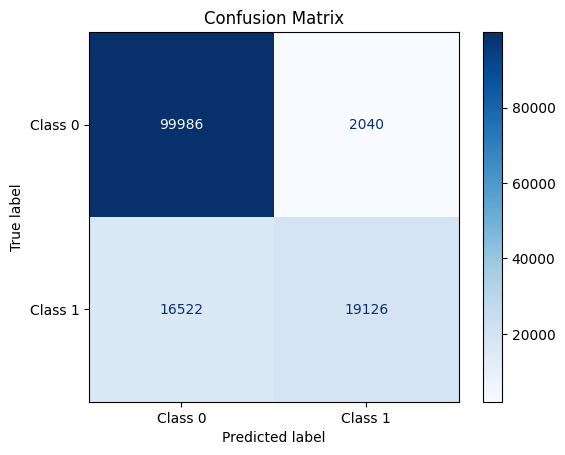

0.7001062035560608

In [16]:
from utils.eval_helpers import evaluate_model_for_recall
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=true_classes, y_pred_proba=all_preds)